#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Задача исследования:** построить модель для предсказания количества заказов такси на следующий час.

**План исследования:**
- изучить данные
- проверить данные на монотонность
- создать признаки
- подготовить данные для обучения
- подобрать гиперпараметры для разных моделей
- обучить разные модели
- испытать модели на тестовой выборке

## Подготовка

1. Импортируем все нужные в работе библиотеки

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

2. Откроем файл с данными

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

3. info

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


- всего 26496 объектов, пропусков нет
- столбец num_orders имеет формат int64

4. head

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные обновляются каждые 10 минут.

5. Проверим монотонность

In [5]:
data.index.is_monotonic

True

Данные монотонны.

6. Ресемплируем данные

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


После ресемплирования осталось 4416 объектов. Мы имеем данные с 1 марта 2018 по 31 августа 2018.

**Вывод** 
1. В этом разделе мы:
- изучили данные 
- проверили на монотонность
- ресемплировали на нужные отрезки времени - по 1 часу

2. Заметили:
- всего в данных 26496 объектов, данные обновляются каждые 10 минут
- данные монотонны
- после ресемплирования осталось 4416 объектов
- данные включают в себя наблюдения с 1 марта 2018 по 31 августа 2018.

## Анализ

Проанализируем данные.

1. Скользящее среднее

In [8]:
data['rolling_mean'] = data.rolling(24).mean()

Зададим размер окна 24 часа.

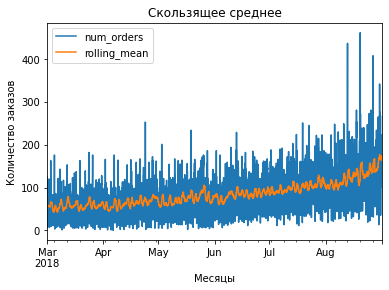

In [9]:
#построим график
data.plot(title='Скользящее среднее');
plt.xlabel('Месяцы');
plt.ylabel('Количество заказов');

На графике видно, что спрос на такси постепенно повышается, в марте наименьшее количество заказов, в августе - наибольшее. Из-за большего спроса в августе можно увидеть более частые изменения спроса с большей амплитудой.

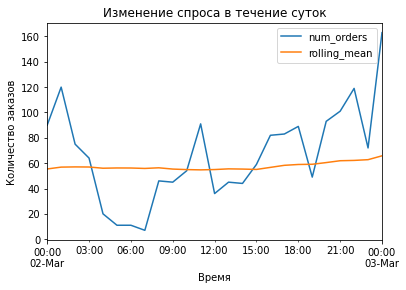

In [10]:
data['2018-03-02 00:00:00':'2018-03-03 00:00:00'].plot(title='Изменение спроса в течение суток');
plt.xlabel('Время');
plt.ylabel('Количество заказов');

Рассмотрим суточное изменение спроса 2 марта 2018. На графике видно, что наименьший спрос бывает в предутреннее время, затем, ближе к началу рабочего дня, спрос резко возрастает, преодолевает пик, снижается, и после этого держится в среднем на одном и том же уровне, увеличиваясь только в вечернее время, когда люди возвращаются с работы, и после.

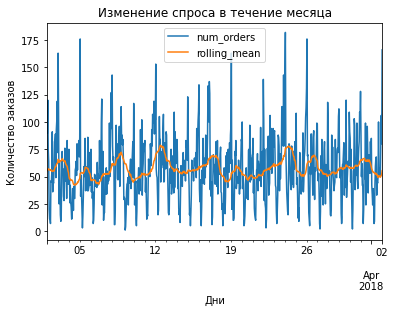

In [11]:
data['2018-03-02 00:00:00':'2018-04-02 00:00:00'].plot(title='Изменение спроса в течение месяца');
plt.xlabel('Дни');
plt.ylabel('Количество заказов');

Рассмотрим изменение спроса в течение месяца. Можно заметить, что в некоторые дни спрос высокий, а в другие низкий, но это не зависит от дней недели, т.к. нельзя заметить цикличность, зависяющую от дней недели.

2. Тренд и сезонность

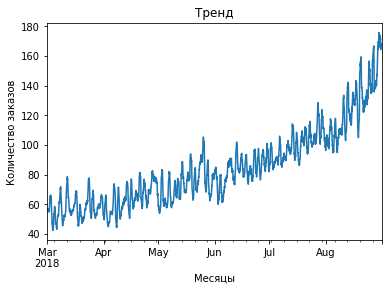

In [12]:
#декомпозируем данные
decomposed = seasonal_decompose(data['num_orders'], period=24)

#рассмотрим тренд
decomposed.trend.plot(title='Тренд');
plt.xlabel('Месяцы');
plt.ylabel('Количество заказов');

Из графика тренда видно, что количество заказов значительно увеличилось с марта по август.

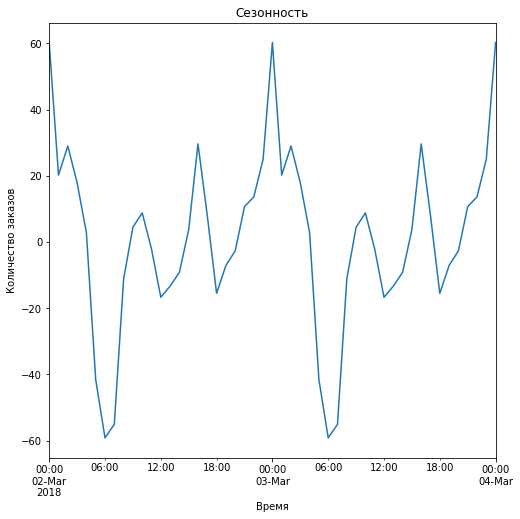

In [13]:
#рассмотрим сезонность
decomposed.seasonal['2018-03-02 00:00:00': '2018-03-04 00:00:00'].plot(title='Сезонность', figsize=(8, 8));
plt.xlabel('Время');
plt.ylabel('Количество заказов');

Рассмотрим график сезонности. На графике видно, что наименьший спрос бывает в примерно 6 часов утра, пики значений - наибольший спрос - приходятся на примерно 10 часов утра, послеобеденное время и 12 часов ночи.

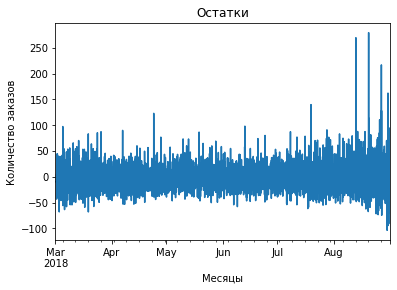

In [14]:
#рассмотрим остатки
decomposed.resid.plot(title='Остатки');
plt.xlabel('Месяцы');
plt.ylabel('Количество заказов');

На графике остатков виден примерный диапазон значений, можно заметить, что в августе появились большие выбивающиеся значения.

3. Создадим признаки

In [15]:
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    #data['shift'] = data['num_orders'].shift(fill_value=0)
    data['shift'] = data['num_orders'].shift()
    #data['shift_24'] = data['num_orders'].shift(24)
    max_lag = 24
    for n_lag in range(1, max_lag + 1):
        data[f"lag_{n_lag}"] = data['num_orders'].shift(n_lag)
    
make_features(data)
data = data.dropna()

In [16]:
data.head()

,num_orders,rolling_mean,year,month,day,dayofweek,hour,shift,lag_1,lag_2,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,55.416667,2018,3,2,4,0,58.0,58.0,113.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,56.875000,2018,3,2,4,1,90.0,90.0,58.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,57.041667,2018,3,2,4,2,120.0,120.0,90.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,56.958333,2018,3,2,4,3,75.0,75.0,120.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,56.000000,2018,3,2,4,4,64.0,64.0,75.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


4. Подготовим нужные выборки

In [17]:
data = data.drop('rolling_mean', axis=1)

In [18]:
#выделим признаки и целевой признак
features = data.drop('num_orders', axis=1)
target = data['num_orders']

In [19]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.1, shuffle=False)

In [20]:
#проверим выборки на монотонность и размер
print(features_train.index.is_monotonic, features_train.shape)
print(features_test.index.is_monotonic, features_test.shape)
print(target_train.index.is_monotonic, target_train.shape)
print(target_test.index.is_monotonic, target_test.shape)

True (3952, 30)
True (440, 30)
True (3952,)
True (440,)


Данные в выборках монотонны - даты и время расположены в хронологическом порядке.

**Вывод**
1. В этом разделе мы:
- рассмотрели скользящее среднее
- рассмотрели тренд, сезонность и остатки
- создали признаки
- подготовили выборки для обучения моделей

2. Заметили:
- спрос на такси постепенно повышается, в марте наименьшее количество заказов, в августе - наибольшее
- наименьший спрос бывает в примерно 6 часов утра
- наибольший спрос приходится на примерно 10 часов утра, послеобеденное время и 12 часов ночи
- в остальное время дня держится в среднем на одном уровне
- количество заказов значительно увеличилось с марта по август.

## Обучение

Рассмотрим модели линейной регрессии, дерева решений, случайного леса, LightGBM.

1. Линейная регрессия

In [21]:
scorer = make_scorer(mean_squared_error)
split = TimeSeriesSplit(n_splits=3)

In [22]:
model = LinearRegression()

rmse = ((cross_val_score(model, features_train, target_train, cv=split, \
                      n_jobs=-1, scoring=scorer)) ** 0.5).mean()

print('Средний RMSE на кросс-валидации модели линейной регрессии составил', rmse)

Средний RMSE на кросс-валидации модели линейной регрессии составил 27.563673403442618


2. Дерево решений

In [23]:
#Подберём лучшие гиперпараметры для модели дерева решений.

decision_tree_params = {
    'max_depth': range(1, 15, 1)
}

model = DecisionTreeRegressor()

grid = GridSearchCV(model, decision_tree_params, cv=split)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 6}

Лучшая глубина для модели дерева решений - 5.

In [24]:
model = DecisionTreeRegressor(max_depth=5, random_state=12345)

rmse = ((cross_val_score(model, features_train, target_train, cv=split, \
                      n_jobs=-1, scoring=scorer)) ** 0.5).mean()
print('Средний RMSE на кросс-валидации модели дерева решений составил', rmse)

Средний RMSE на кросс-валидации модели дерева решений составил 32.11451472848696


3. Случайный лес

In [25]:
decision_tree_params = {
    'max_depth': range(1, 15, 1),
    'n_estimators': range(1, 101, 10)
}

model = RandomForestRegressor()
grid = GridSearchCV(model, decision_tree_params, cv=split)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 13, 'n_estimators': 51}

Лучшие гиперпараметры для модели случайного леса:
- максимальная глубина - 13
- количество деревьев - 71

In [26]:
model = RandomForestRegressor(max_depth=14, n_estimators=91, random_state=12345)

rmse = ((cross_val_score(model, features_train, target_train, cv=split, scoring=scorer) ** 0.5)).mean()

print('Средний RMSE на кросс-валидации модели случайного леса составил', rmse)

Средний RMSE на кросс-валидации модели случайного леса составил 27.107804438063024


4. LightGBM

Для модели LightGBM подберём лучшие гиперпараметры с помощью GridSearchCV.

In [27]:
#light_gbm_params = {
#    'max_depth': range(1, 15, 1),
#    'n_estimators': range(1, 101, 10)
#}

#model = lgb.LGBMRegressor()
#grid = GridSearchCV(model, light_gbm_params, cv=split)
#grid.fit(features_train, target_train)
#grid.best_params_

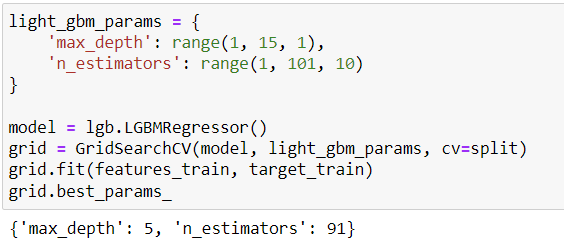

Лучшие гиперпараметры для LightGBM: максимальная глубина - 5, количество деревьев - 91.

In [28]:
model = lgb.LGBMRegressor(max_depth=5, n_estimators=91, random_state=12345)

rmse = ((cross_val_score(model, features_train, target_train, scoring=scorer, cv=split)) ** 0.5).mean()

print('Средний RMSE на кросс-валидации модели LightGBM составил', rmse)

Средний RMSE на кросс-валидации модели LightGBM составил 26.275544044950532


**Вывод**
1. В этом разделе мы:
- подобрали для моделей лучшие гиперпараметры с помощью GridSearchCV
- вычислили RMSE на валидационной выборке с помощью кросс-валидации

2. Заметили:
- лучший гиперпараметр для модели дерева решений: максимальная глубина - 8
- лучшие гиперпараметры для модели случайного леса: максимальная глубина - 14, количество деревьев - 61
- лучшие гиперпараметры для модели случайного леса: максимальная глубина - 4, количество деревьев - 91


- среднее RMSE модели линейной регрессии составило 32.56 на кросс-валидации
- среднее RMSE модели дерева решений составило 31.3 на кросс-валидации
- среднее RMSE модели случайного леса составило 28.2 на кросс-валидации
- среднее RMSE модели LightGBM составило 27.95 на кросс-валидации


- наибольшее RMSE у модели линейной регрессии
- наименьшее RMSE у модели LightGBM

## Тестирование

Протестируем LightGBM, т.к. она дала лучший результат на обучении.

In [29]:
model = lgb.LGBMRegressor(max_depth=5, n_estimators=91, random_state=12345)

model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

rmse_lgbm = mean_squared_error(target_test, predicted_test) ** 0.5
print('RMSE модели LightGBM на тестовой выборке:', rmse_lgbm)

RMSE модели LightGBM на тестовой выборке: 41.36372023008206


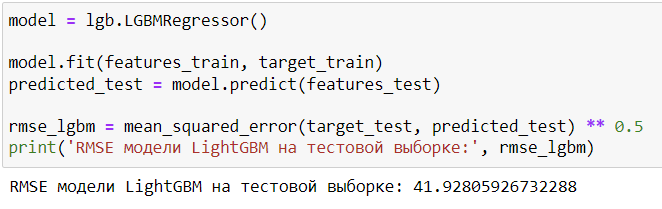

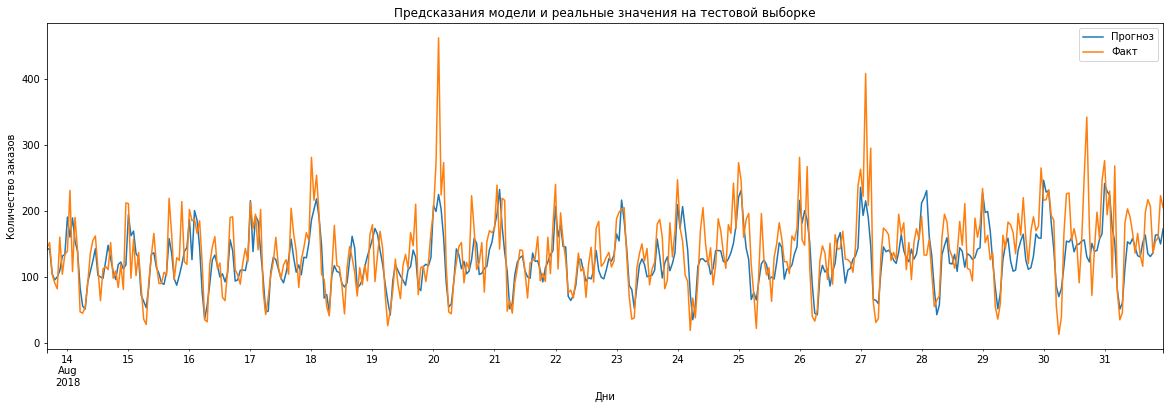

In [30]:
pd.DataFrame({
    'Прогноз': predicted_test,
    'Факт': target_test
}).plot(title='Предсказания модели и реальные значения на тестовой выборке', figsize=(20, 6));
plt.xlabel('Дни');
plt.ylabel('Количество заказов');

**Модель LightGBM преодолела порог RMSE 48.**

**Вывод**
1. В этом разделе мы:
- вычислили RMSE на тестовой выборке

2. Заметили:
- модель LightGBM преодолела порог RMSE 48.

**ОБЩИЙ ВЫВОД**

1. В этом проекте мы:
- рассмотрели данные
- подготовили их для обучения
- рассмотрели модели линейной регрессии, дерева решений, случайного леса, LightGBM
- подобрали для моделей лучшие гиперпараметры
- рассчитали RMSE на валидационной выборке с помощью кросс-валидации
- рассчитали RMSE на кросс-валидации

2. Заметили:
- данные включают в себя наблюдения с 1 марта 2018 по 31 августа 2018


- спрос на такси постепенно повышается, в марте наименьшее количество заказов, в августе - наибольшее
- наименьший спрос бывает в предутреннее время
- ближе к началу рабочего дня спрос резко возрастает, преодолевает пик наибольшего значения
- в остальное время дня держится в среднем на одном уровне


- наибольшее RMSE у модели линейной регрессии
- наименьшее RMSE у модели LightGBM


- RMSE модели LightGBM на тестовой выборке: 40.67 => 41.36

**Для прогноза количества заказов такси на следующий час подходит модель LightGBM с гиперпараметрами:**
- **максимальная глубина - 4**
- **количество деревьев - 91**

**, т.к. она дала лучшее значение RMSE на тренировочной выборке.**